In [17]:
import math
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from collections import defaultdict
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.decomposition import PCA
import seaborn as sns

In [18]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('PyTorch/GPU')
else:
    device = torch.device('cpu')
    print('PyTorch/CPU')

PyTorch/CPU


In [19]:
config = {
    'batch_size': 32,
    'learning_rate': 0.0002,
    'epochs': 10,
    'latent_size': 100,
    'data_size': 371,
    'model_dir': './'
}

In [66]:
features_df = pd.read_csv('preprocessed_features.csv')
print("features shape:", features_df.shape)

target_df = pd.read_csv('Encoded_target.csv')
print("available target lables:", target_df.columns.tolist())

sel_label =  'Arousal'
print(f"selected target label is '{sel_label}'")

features shape: (1280, 371)
available target lables: ['Valence', 'Arousal', 'Dominance', 'Liking']
selected target label is 'Arousal'


In [21]:
class DatasetDEAP(Dataset):
    
    def __init__(self, features_df, target_df, transform=None):
        assert len(features_df) == len(target_df)
        self.features = torch.FloatTensor(features_df.values)
        self.target = torch.FloatTensor(target_df.values)
        self.transform = transform
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        features_ = self.features[index]
        if self.transform is not None:
            features_ = self.transform(features_)
        return features_, self.target[index]
    

data = DatasetDEAP(features_df, target_df["Arousal"])
data_loader = DataLoader(data, batch_size=config['batch_size'], shuffle=True)

In [22]:
batches = enumerate(data_loader)
batch_idx, (features_batch, target_batch) = next(batches)
print(features_batch.data.shape)
print(torch.min(features_batch.data), torch.max(features_batch.data))

torch.Size([32, 371])
tensor(-1.) tensor(0.9986)


In [23]:
class Generator(nn.Module):
    
    def __init__(self, input_size=config['latent_size'], output_size=config['data_size'], hidden_size=128):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
                                 nn.Linear(input_size, hidden_size),
                                 nn.LeakyReLU(0.2, inplace=True),
                                 nn.Linear(hidden_size, hidden_size*2),
                                 nn.LeakyReLU(0.2, inplace=True),
                                 nn.Linear(hidden_size*2, output_size),
                                 nn.Tanh()
                                )
        
    def forward(self, x):
        x = self.net(x)
        return x

In [24]:
class Discriminator(nn.Module):
    
    def __init__(self, input_size=config['data_size'], hidden_size=128):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
                                 nn.Linear(input_size, hidden_size*2),
                                 nn.LeakyReLU(0.2, inplace=True),
                                 nn.Dropout(0.3),
                                 nn.Linear(hidden_size*2, hidden_size),
                                 nn.LeakyReLU(0.2, inplace=True),
                                 nn.Dropout(0.3),
                                 nn.Linear(hidden_size, 1),
                                 nn.Sigmoid()
                                )
        
    def forward(self, x):
        x = self.net(x)
        return x

In [25]:
generator = Generator()
discriminator = Discriminator()

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=config['learning_rate'])
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=config['learning_rate'])

criterion = torch.nn.BCELoss()

In [26]:
def train_gran(generator=generator, discriminator=discriminator, real_train_loader=data_loader,
               batch_size=config['batch_size'], latent_size=config['latent_size'], num_epochs=10,
               save_models=True, plot_losses=True, device='cpu'):
    
    generator.to(device)
    discriminator.to(device)
    
    history = defaultdict(list)
    
    # loop over epochs
    for epoch in range(num_epochs):
        
        d_loss = 0.
        g_loss = 0.

        # loop over batches in each epochs
        for (features, _) in real_train_loader:
            
            features = features.view(batch_size, -1).to(device)
            
            # train discriminator
            # --------------------------
            discriminator.train()
            generator.eval()
            
            preds = discriminator(features)
            real_loss = criterion(preds, torch.ones_like(preds).to(device))
            
            fake_features = generator(torch.randn(batch_size, latent_size).to(device))
            fake_preds = discriminator(fake_features)
            fake_loss = criterion(fake_preds, torch.zeros_like(fake_preds).to(device))
            
            discriminator_loss = real_loss + fake_loss
            discriminator.zero_grad();
            discriminator_loss.backward()
            discriminator_optimizer.step()
            
            # train generator
            # --------------------------
            generator.train()
            discriminator.eval()
            
            forged_feafures = generator(torch.randn(batch_size, latent_size).to(device))
            forged_preds = discriminator(forged_feafures)
            forged_loss = criterion(forged_preds, torch.ones_like(forged_preds).to(device))
            
            generator.zero_grad();
            forged_loss.backward()
            generator_optimizer.step()
            
            # losses
            d_loss += discriminator_loss
            g_loss += forged_loss
            
        # statistics
        d_loss /= len(real_train_loader)
        g_loss /= len(real_train_loader)   
        print("epoch: {}/{}, d_loss:{:.5f}, g_loss:{:.5f}".format(epoch+1, num_epochs, d_loss, g_loss))
        history['g_losses'].append(g_loss.data.item())
        history['d_losses'].append(d_loss.data.item())
        
    # Save the model checkpoints 
    if save_models:
        torch.save(generator.state_dict(), 'model-gen.ckpt')
        torch.save(discriminator.state_dict(), 'model-discr.ckpt')
    
    # plot losses
    if plot_losses:
        plt.plot(history['g_losses'], label='generator')
        plt.plot(history['d_losses'], label='discriminator')
        plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend()
    
    return history

epoch: 1/500, d_loss:1.01777, g_loss:0.60646
epoch: 2/500, d_loss:1.13913, g_loss:0.64685
epoch: 3/500, d_loss:0.92531, g_loss:0.97432
epoch: 4/500, d_loss:0.73776, g_loss:1.34662
epoch: 5/500, d_loss:0.61774, g_loss:1.70530
epoch: 6/500, d_loss:0.17738, g_loss:3.02478
epoch: 7/500, d_loss:0.23520, g_loss:2.83448
epoch: 8/500, d_loss:0.49137, g_loss:2.16310
epoch: 9/500, d_loss:0.74788, g_loss:1.78115
epoch: 10/500, d_loss:1.31858, g_loss:1.08854
epoch: 11/500, d_loss:0.66124, g_loss:2.05003
epoch: 12/500, d_loss:0.69894, g_loss:1.71110
epoch: 13/500, d_loss:0.82077, g_loss:1.56850
epoch: 14/500, d_loss:0.47451, g_loss:2.31455
epoch: 15/500, d_loss:0.61459, g_loss:1.98028
epoch: 16/500, d_loss:0.44601, g_loss:2.26804
epoch: 17/500, d_loss:0.43967, g_loss:2.43752
epoch: 18/500, d_loss:0.46059, g_loss:2.41243
epoch: 19/500, d_loss:0.67122, g_loss:1.90597
epoch: 20/500, d_loss:0.64924, g_loss:1.79756
epoch: 21/500, d_loss:0.97663, g_loss:1.22867
epoch: 22/500, d_loss:0.92406, g_loss:1.285

epoch: 178/500, d_loss:1.34287, g_loss:0.88157
epoch: 179/500, d_loss:1.31552, g_loss:0.94161
epoch: 180/500, d_loss:1.09174, g_loss:1.11938
epoch: 181/500, d_loss:1.21534, g_loss:0.91607
epoch: 182/500, d_loss:1.12255, g_loss:1.04791
epoch: 183/500, d_loss:1.21280, g_loss:0.95403
epoch: 184/500, d_loss:1.24021, g_loss:1.03216
epoch: 185/500, d_loss:1.15132, g_loss:1.05879
epoch: 186/500, d_loss:1.25663, g_loss:0.97716
epoch: 187/500, d_loss:1.18259, g_loss:1.02082
epoch: 188/500, d_loss:1.14383, g_loss:1.06485
epoch: 189/500, d_loss:1.22935, g_loss:0.97739
epoch: 190/500, d_loss:1.30544, g_loss:0.87182
epoch: 191/500, d_loss:1.04621, g_loss:1.07748
epoch: 192/500, d_loss:1.14396, g_loss:1.05121
epoch: 193/500, d_loss:1.20765, g_loss:0.96654
epoch: 194/500, d_loss:1.11858, g_loss:1.04593
epoch: 195/500, d_loss:1.23872, g_loss:1.00646
epoch: 196/500, d_loss:1.17875, g_loss:0.99115
epoch: 197/500, d_loss:1.16081, g_loss:1.01415
epoch: 198/500, d_loss:1.11460, g_loss:1.06383
epoch: 199/50

epoch: 353/500, d_loss:1.38212, g_loss:0.90057
epoch: 354/500, d_loss:1.20459, g_loss:1.02651
epoch: 355/500, d_loss:1.43354, g_loss:0.81567
epoch: 356/500, d_loss:1.23705, g_loss:1.12972
epoch: 357/500, d_loss:1.13830, g_loss:0.99656
epoch: 358/500, d_loss:1.22914, g_loss:0.90646
epoch: 359/500, d_loss:1.21539, g_loss:1.03741
epoch: 360/500, d_loss:1.29544, g_loss:0.92078
epoch: 361/500, d_loss:1.25853, g_loss:0.92541
epoch: 362/500, d_loss:1.28712, g_loss:0.96972
epoch: 363/500, d_loss:1.30622, g_loss:0.90631
epoch: 364/500, d_loss:1.14150, g_loss:1.09584
epoch: 365/500, d_loss:1.28877, g_loss:0.92064
epoch: 366/500, d_loss:1.16356, g_loss:1.06704
epoch: 367/500, d_loss:1.19749, g_loss:0.97895
epoch: 368/500, d_loss:1.35206, g_loss:0.77857
epoch: 369/500, d_loss:1.22172, g_loss:1.00681
epoch: 370/500, d_loss:1.22670, g_loss:1.03445
epoch: 371/500, d_loss:1.24146, g_loss:0.87113
epoch: 372/500, d_loss:1.20953, g_loss:1.01512
epoch: 373/500, d_loss:1.27194, g_loss:0.88776
epoch: 374/50

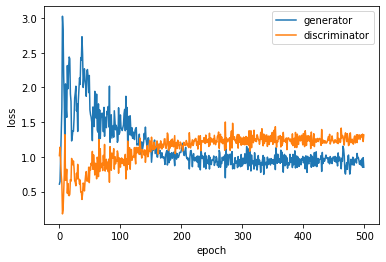

In [27]:
history = train_gran(num_epochs=500, device=device)

In [28]:
def generate_gan_data(generator=generator, n_samples=1, latent_size=config['latent_size'], device='cpu'):
    gan_data = generator(torch.randn(n_samples, latent_size).to(device))
    return np.array(gan_data.data)

GAN shape: (5000, 371)


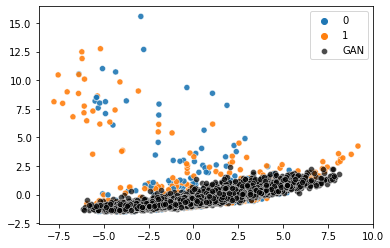

In [29]:
# real data
pca = PCA(n_components=2)
pca.fit(features_df.values)
features_pca = pca.transform(features_df.values)
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=target_df['Arousal'], alpha=0.9)

# GAN data
gan_features = generate_gan_data(n_samples=5000)
print("GAN shape:", gan_features.shape)
gan_features_pca = pca.transform(gan_features)
sns.scatterplot(x=gan_features_pca[:, 0], y=gan_features_pca[:, 1], color='k', alpha=0.7, label='GAN');

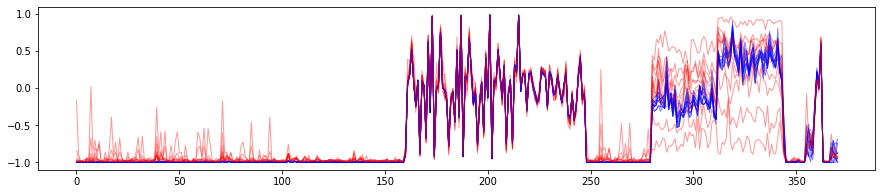

In [32]:
fig, ax = plt.subplots(figsize=(15,3))
for i in range(10):
    plt.plot(features_df.values[i, :], color='b', lw=1, alpha=0.5)
    plt.plot(gan_features[i, :], color='red', lw=1, alpha=0.4)

In [15]:
gan_features_df = pd.DataFrame(gan_features, columns=features_df.columns)
gan_features_df.to_csv("gan_features.csv", index=False)

In [58]:
embedding = torch.nn.Embedding(10, 3 )
input = torch.LongTensor([1])
input.shape
embedding(input)

tensor([[ 1.7312,  2.6569, -1.0617]], grad_fn=<EmbeddingBackward>)